## Import

In [1]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProjetOpenClassrooms/RecoApp/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProjetOpenClassrooms/RecoApp


In [2]:
ROOT = "./data"

In [3]:
!pip uninstall -y numpy #scikit-surprise
!pip install numpy==1.26.4
!pip install surprise
!pip install faiss-cpu

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 r

  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2555844 sha256=e06fffc510aeefaf6de2c132390ea780299a6388f8b193b357fee9a03aeb8001
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 96.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import glob
import pickle
import numpy as np
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import normalize


In [5]:
# Load all hourly click CSV files, concatenate them into a single DataFrame,
# and display the number of files found, the final shape, and a preview of the data.

files = glob.glob("./data/clicks/clicks_hour_*.csv")
print("Fichiers trouvés :", len(files))

dfs = [pd.read_csv(f) for f in files]
clicks = pd.concat(dfs, ignore_index=True)

print("Shape final :", clicks.shape)
print(clicks.head())



Fichiers trouvés : 385
Shape final : (2988181, 12)
  user_id        session_id  session_start session_size click_article_id  \
0   43561  1506965780874610  1506965780000            3            16129   
1   43561  1506965780874610  1506965780000            3           224658   
2   43561  1506965780874610  1506965780000            3           225463   
3   81880  1506965781665611  1506965781000            2           300470   
4   81880  1506965781665611  1506965781000            2           272660   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506965953045                 4                 1       17             1   
1   1506972498754                 4                 1       17             1   
2   1506972528754                 4                 1       17             1   
3   1506965976649                 4                 1       17             1   
4   1506966006649                 4                 1       17             1   

  click_reg

In [6]:
print("Aperçu des données :")
print(clicks.head())

print("Taille du dataset :")
print("Lignes :", clicks.shape[0])
print("Colonnes :", clicks.shape[1])
print("Shape :", clicks.shape)


print("Colonnes et types :")
for col in clicks.columns:
    print(f"{col} : {clicks[col].dtype}")




Aperçu des données :
  user_id        session_id  session_start session_size click_article_id  \
0   43561  1506965780874610  1506965780000            3            16129   
1   43561  1506965780874610  1506965780000            3           224658   
2   43561  1506965780874610  1506965780000            3           225463   
3   81880  1506965781665611  1506965781000            2           300470   
4   81880  1506965781665611  1506965781000            2           272660   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506965953045                 4                 1       17             1   
1   1506972498754                 4                 1       17             1   
2   1506972528754                 4                 1       17             1   
3   1506965976649                 4                 1       17             1   
4   1506966006649                 4                 1       17             1   

  click_region click_referrer_type  
0   

In [7]:
# Load the pickled article embeddings and inspect their structure by checking the container type,
# number of keys (if dict), an example key/value, and the shape of the embedding array.

with open("./data/articles_embeddings.pickle", "rb") as f:
    emb = pickle.load(f)

print(type(emb))
if isinstance(emb, dict):
    print("Nb keys:", len(emb))
    k = list(emb.keys())[0]
    print("Example key:", k)
    print("Value type:", type(emb[k]))
    print("Value shape:", np.array(emb[k]).shape)
else:
    print("Shape:", np.array(emb).shape)


<class 'numpy.ndarray'>
Shape: (364047, 250)


In [8]:
# Load raw article embeddings, validate alignment with metadata, merge embeddings with article/category IDs,
# normalize the embedding vectors, and save the final processed array for later use.

with open("./data/articles_embeddings.pickle", "rb") as f:
    emb = pickle.load(f)

print("Embeddings shape:", emb.shape)


meta = pd.read_csv("./data/articles_metadata.csv")

assert len(meta) == emb.shape[0], \
    f"ERROR: {len(meta)} articles dans metadata mais {emb.shape[0]} embeddings"

print("Metadata ok & aligned")


emb_df = pd.DataFrame(emb)
emb_df["article_id"] = meta["article_id"]
emb_df["category"] = meta["category_id"]


emb_df = emb_df.set_index("article_id")

print(emb_df.head())


emb_vectors = emb_df.iloc[:, :-1].values
emb_normalized = normalize(emb_vectors, norm="l2")

emb_df.iloc[:, :-1] = emb_normalized


np.save("embeddings.npy", emb_normalized)

print("embeddings.npy saved")
print("DataFrame avec catégories prête !")


Embeddings shape: (364047, 250)
Metadata ok & aligned
                   0         1         2         3         4         5  \
article_id                                                               
0          -0.161183 -0.957233 -0.137944  0.050855  0.830055  0.901365   
1          -0.523216 -0.974058  0.738608  0.155234  0.626294  0.485297   
2          -0.619619 -0.972960 -0.207360 -0.128861  0.044748 -0.387535   
3          -0.740843 -0.975749  0.391698  0.641738 -0.268645  0.191745   
4          -0.279052 -0.972315  0.685374  0.113056  0.238315  0.271913   

                   6         7         8         9  ...       241       242  \
article_id                                          ...                       
0          -0.335148 -0.559561 -0.500603  0.165183  ...  0.313999  0.636412   
1          -0.715657 -0.897996 -0.359747  0.398246  ...  0.823124  0.412688   
2          -0.730477 -0.066126 -0.754899 -0.242004  ...  0.473184  0.377866   
3          -0.825593 -0.710591 -

In [9]:
emb_dict = {
    idx: emb_df.iloc[i, :-1].values
    for i, idx in enumerate(emb_df.index)
}

import pickle
with open("embeddings_dict.pickle", "wb") as f:
    pickle.dump(emb_dict, f)

print("embeddings_dict.pickle saved")


embeddings_dict.pickle saved


-----------

In [10]:
import pandas as pd
import numpy as np

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split


In [11]:

print("Aperçu du DataFrame clicks :")
print(clicks.head())


interactions = clicks[["user_id", "click_article_id"]].copy()


interactions["rating"] = 1.0

print("Aperçu des interactions :")
print(interactions.head())

print("Taille du dataset d'interactions :")
print(interactions.shape)


Aperçu du DataFrame clicks :
  user_id        session_id  session_start session_size click_article_id  \
0   43561  1506965780874610  1506965780000            3            16129   
1   43561  1506965780874610  1506965780000            3           224658   
2   43561  1506965780874610  1506965780000            3           225463   
3   81880  1506965781665611  1506965781000            2           300470   
4   81880  1506965781665611  1506965781000            2           272660   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506965953045                 4                 1       17             1   
1   1506972498754                 4                 1       17             1   
2   1506972528754                 4                 1       17             1   
3   1506965976649                 4                 1       17             1   
4   1506966006649                 4                 1       17             1   

  click_region click_referrer_typ

In [12]:

reader = Reader(rating_scale=(0, 1))


data = Dataset.load_from_df(
    interactions[["user_id", "click_article_id", "rating"]],
    reader
)


trainset, testset = train_test_split(
    data,
    test_size=0.2,
    random_state=42
)

print("Nombre d'interactions dans le train :")
print(trainset.n_ratings)

print("Nombre d'interactions dans le test :")
print(len(testset))

print("Nombre d'utilisateurs connus (train) :")
print(trainset.n_users)

print("Nombre d'articles connus (train) :")
print(trainset.n_items)


Nombre d'interactions dans le train :
2390544
Nombre d'interactions dans le test :
597637
Nombre d'utilisateurs connus (train) :
318478
Nombre d'articles connus (train) :
40755


EDA

In [13]:
print("Aperçu des données :")
display(clicks.head())

print("Taille du dataset :")
print(f"Lignes : {clicks.shape[0]}")
print(f"Colonnes : {clicks.shape[1]}")

print("\nColonnes et types :")
for col in clicks.columns:
    print(f"{col} : {clicks[col].dtype}")


Aperçu des données :


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,43561,1506965780874610,1506965780000,3,16129,1506965953045,4,1,17,1,14,2
1,43561,1506965780874610,1506965780000,3,224658,1506972498754,4,1,17,1,14,2
2,43561,1506965780874610,1506965780000,3,225463,1506972528754,4,1,17,1,14,2
3,81880,1506965781665611,1506965781000,2,300470,1506965976649,4,1,17,1,25,2
4,81880,1506965781665611,1506965781000,2,272660,1506966006649,4,1,17,1,25,2


Taille du dataset :
Lignes : 2988181
Colonnes : 12

Colonnes et types :
user_id : object
session_id : object
session_start : object
session_size : object
click_article_id : object
click_timestamp : object
click_environment : object
click_deviceGroup : object
click_os : object
click_country : object
click_region : object
click_referrer_type : object


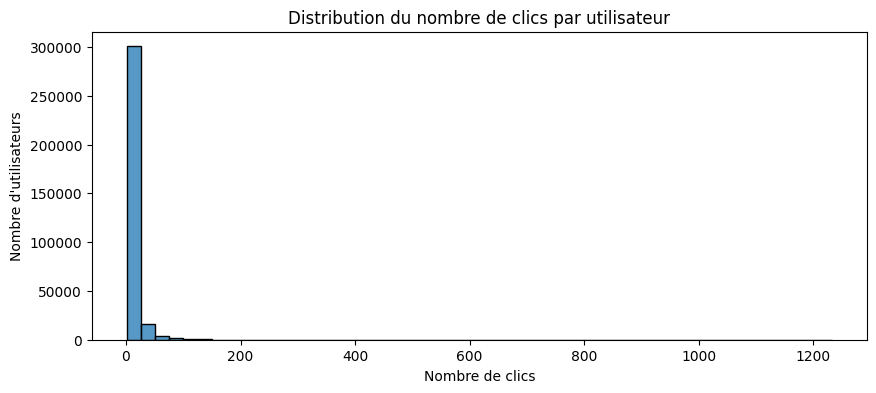

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.histplot(clicks["user_id"].value_counts(), bins=50)
plt.title("Distribution du nombre de clics par utilisateur")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre d'utilisateurs")
plt.show()


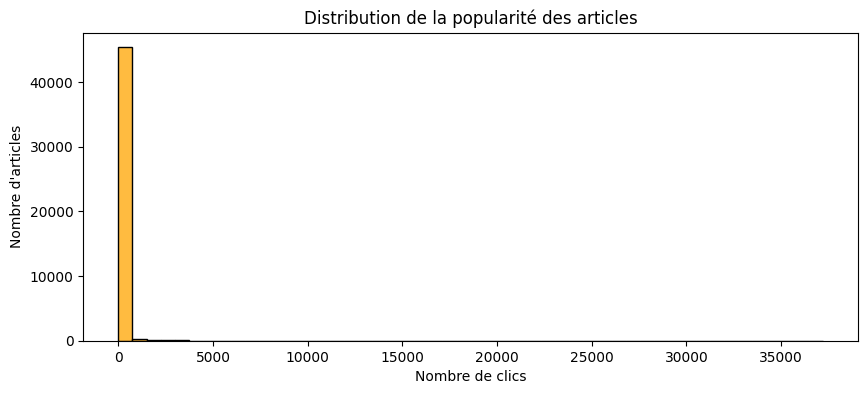

In [15]:
plt.figure(figsize=(10,4))
sns.histplot(clicks["click_article_id"].value_counts(), bins=50, color="orange")
plt.title("Distribution de la popularité des articles")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre d'articles")
plt.show()


In [16]:
n_users = clicks["user_id"].nunique()
n_items = clicks["click_article_id"].nunique()
n_interactions = len(clicks)

sparsity = 1 - (n_interactions / (n_users * n_items))

print(f"Sparsité de la matrice : {sparsity:.4f} (soit {sparsity*100:.2f}% d'entrées vides)")


Sparsité de la matrice : 0.9998 (soit 99.98% d'entrées vides)


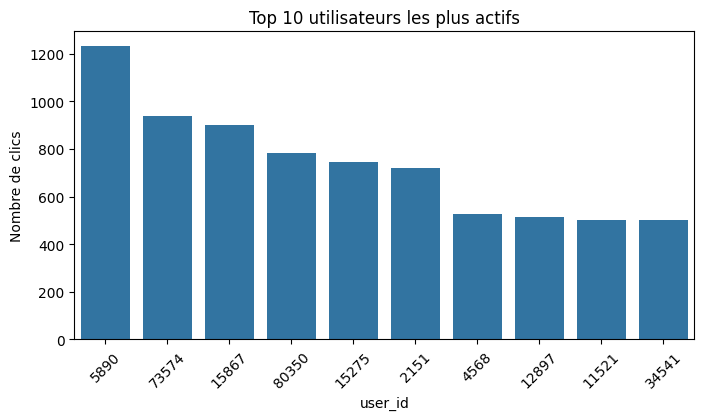

In [17]:
top_users = clicks["user_id"].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_users.index.astype(str), y=top_users.values)
plt.title("Top 10 utilisateurs les plus actifs")
plt.xticks(rotation=45)
plt.xlabel("user_id")
plt.ylabel("Nombre de clics")
plt.show()


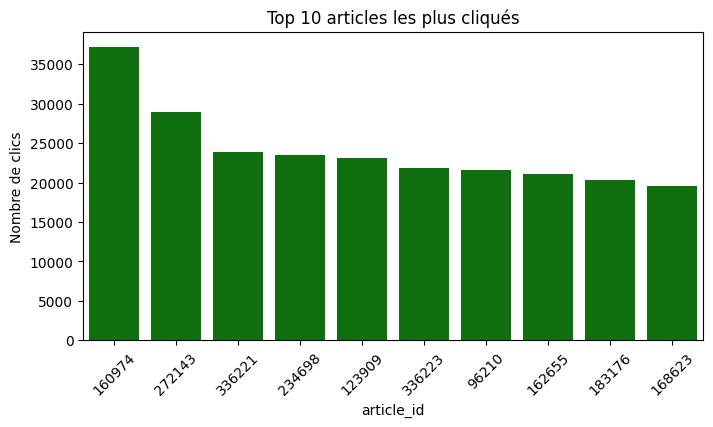

In [18]:
top_items = clicks["click_article_id"].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_items.index.astype(str), y=top_items.values, color="green")
plt.title("Top 10 articles les plus cliqués")
plt.xticks(rotation=45)
plt.xlabel("article_id")
plt.ylabel("Nombre de clics")
plt.show()


Préparation des données pour Surprise + Split Train/Test

In [19]:
articles_df = pd.read_csv("./data/articles_metadata.csv")  # adapte le chemin exact
print(articles_df.head())


   article_id  category_id  created_at_ts  publisher_id  words_count
0           0            0  1513144419000             0          168
1           1            1  1405341936000             0          189
2           2            1  1408667706000             0          250
3           3            1  1408468313000             0          230
4           4            1  1407071171000             0          162


In [20]:

dict_article_categories = (
    articles_df
    .set_index("article_id")["category_id"]
    .to_dict()
)


clicks["category_id"] = clicks["click_article_id"].map(dict_article_categories).astype(int)

print(clicks.head())


  user_id        session_id  session_start session_size click_article_id  \
0   43561  1506965780874610  1506965780000            3            16129   
1   43561  1506965780874610  1506965780000            3           224658   
2   43561  1506965780874610  1506965780000            3           225463   
3   81880  1506965781665611  1506965781000            2           300470   
4   81880  1506965781665611  1506965781000            2           272660   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506965953045                 4                 1       17             1   
1   1506972498754                 4                 1       17             1   
2   1506972528754                 4                 1       17             1   
3   1506965976649                 4                 1       17             1   
4   1506966006649                 4                 1       17             1   

  click_region click_referrer_type  category_id  
0           

In [21]:
clicks["total_click"] = (
    clicks.groupby("user_id")["click_article_id"].transform("count")
)


In [22]:
clicks["total_click_by_category"] = (
    clicks.groupby(["user_id", "category_id"])["click_article_id"].transform("count")
)


In [23]:
clicks["rating"] = clicks["total_click_by_category"] / clicks["total_click"]


In [24]:

clicks_rating = clicks.drop(columns=["click_article_id"])

clicks_rating = clicks_rating.drop_duplicates(subset=["user_id", "category_id"])

print(clicks_rating.shape)
print(clicks_rating.head())


(1882302, 15)
  user_id        session_id  session_start session_size click_timestamp  \
0   43561  1506965780874610  1506965780000            3   1506965953045   
1   43561  1506965780874610  1506965780000            3   1506972498754   
3   81880  1506965781665611  1506965781000            2   1506965976649   
4   81880  1506965781665611  1506965781000            2   1506966006649   
5   81881  1506965782824612  1506965782000            3   1506965813474   

  click_environment click_deviceGroup click_os click_country click_region  \
0                 4                 1       17             1           14   
1                 4                 1       17             1           14   
3                 4                 1       17             1           25   
4                 4                 1       17             1           25   
5                 4                 1       17             1           21   

  click_referrer_type  category_id  total_click  total_click_by_category

In [25]:


clicks_rating = clicks_rating[clicks_rating["user_id"] < 30000].copy()

print("Taille du dataset réduit :", clicks_rating.shape)
print(clicks_rating.head())


Taille du dataset réduit : (320234, 15)
   user_id        session_id  session_start session_size click_timestamp  \
55   19706  1506965791317631  1506965791000            2   1506966137205   
56   19706  1506965791317631  1506965791000            2   1506966167205   
77   22009  1506965800397640  1506965800000            3   1506967211950   
78   22009  1506965800397640  1506965800000            3   1506967281914   
79   22009  1506965800397640  1506965800000            3   1506967311914   

   click_environment click_deviceGroup click_os click_country click_region  \
55                 4                 3       20             1           13   
56                 4                 3       20             1           13   
77                 4                 1       17             1           25   
78                 4                 1       17             1           25   
79                 4                 1       17             1           25   

   click_referrer_type  category_i

In [26]:
from surprise import Dataset, Reader

reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(
    clicks_rating[["user_id", "category_id", "rating"]],
    reader
)


In [27]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


KNNBaseline

Le modèle baseline compare les comportements des utilisateurs : il regarde quels utilisateurs cliquent sur les mêmes types d’articles. Il trouve les voisins les plus proches, puis recommande les articles que ces voisins ont appréciés, en tenant compte des biais.

In [28]:
from surprise import KNNBaseline
from surprise import accuracy


sim_options = {
    "name": "pearson_baseline",
    "user_based": True,
}

algo_knn_base = KNNBaseline(sim_options=sim_options)


algo_knn_base.fit(trainset)


predictions = algo_knn_base.test(testset)


print("RMSE:", accuracy.rmse(predictions))
print("MAE:", accuracy.mae(predictions))


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0958
RMSE: 0.09584945823222199
MAE:  0.0454
MAE: 0.04539611223416931


In [29]:

trainset_items_inner = list(trainset.all_items())
all_categories = [trainset.to_raw_iid(inner_id) for inner_id in trainset_items_inner]

def recommend_cf_baseline(user_id, k=5):
    return recommend_for_user(
        algo_knn_base,
        trainset,
        user_id,
        all_categories,
        n=k
    )

def model_knn_baseline(user_id, k=5):
    return recommend_cf_baseline(user_id, k)


KNNWithMeans

KNNWithMeans utilise un filtrage collaboratif user-based : il calcule la similarité entre utilisateurs (cosine) et prédit quelles catégories un utilisateur va préférer en se basant sur les goûts d’utilisateurs similaires.
Ensuite, pour les catégories prédites comme les plus pertinentes, sélectionne les articles les plus populaires dans ces catégories tout en excluant ceux que l’utilisateur a déjà vus.Le résultat final est une recommandation d’articles basée à la fois sur les comportements d’utilisateurs voisins et sur la popularité réelle des articles dans ces catégories.

In [30]:
from surprise import KNNWithMeans

sim_options = {
    "name": "cosine",
    "user_based": True
}

algo_knn_means = KNNWithMeans(sim_options=sim_options)


algo_knn_means.fit(trainset)


predictions_knn = algo_knn_means.test(testset)


print("RMSE:", accuracy.rmse(predictions_knn))
print("MAE:", accuracy.mae(predictions_knn))


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.0888
RMSE: 0.08877035244361639
MAE:  0.0423
MAE: 0.04233224641294146


In [31]:
def recommend_for_user(model, trainset, user_id, all_categories, n=5):


    seen = set([iid for (iid, _) in trainset.ur[ trainset.to_inner_uid(user_id) ]])

    predictions = []
    for category in all_categories:
        inner_iid = trainset.to_inner_iid(category)

        if inner_iid not in seen:
            pred = model.predict(uid=user_id, iid=category)
            predictions.append((category, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]


In [32]:
with open("anti_testset.pkl", "rb") as f:
    anti_testset = pickle.load(f)

print("Anti-testset chargé.")


Anti-testset chargé.


In [33]:
anti_testset = trainset.build_anti_testset()



In [34]:
import pickle

with open("anti_testset.pkl", "wb") as f:
    pickle.dump(anti_testset, f)

print("Anti-testset sauvegardé.")


Anti-testset sauvegardé.


In [35]:
user_id = 19706


In [36]:
trainset_items_inner = trainset.all_items()


categories = [trainset.to_raw_iid(inner_id) for inner_id in trainset_items_inner]
categories = list(map(int, categories))


In [37]:
recommend_for_user(algo_knn_means, trainset, user_id, categories, n=5)


[(62, 0.1270894502479127),
 (156, 0.11604296604296604),
 (455, 0.10510588193227469),
 (7, 0.0719164150272508),
 (174, 0.06351749523624525)]

In [38]:
import pickle

with open("knn_with_means_model.pkl", "wb") as f:
    pickle.dump(algo_knn_means, f)


In [39]:
def get_seen_articles(clicks_df, user_id):
    return set(clicks_df[clicks_df["user_id"] == user_id]["click_article_id"].unique())


In [40]:
def compute_popular_articles(clicks_df):
    return (
        clicks_df.groupby(["click_article_id", "category_id"])
        .size()
        .reset_index(name="popularity")
        .rename(columns={"click_article_id": "article_id"})
    )


In [41]:
def recommend_articles(
    categories_ranked,
    clicks_df,
    articles_popularity_df,
    user_id,
    n=5
):
    seen = get_seen_articles(clicks_df, user_id)

    recommendations = []

    for category, score in categories_ranked:

        subset = articles_popularity_df[articles_popularity_df["category_id"] == category]


        subset = subset.sort_values("popularity", ascending=False)


        for _, row in subset.iterrows():
            art_id = row["article_id"]

            if art_id not in seen:
                recommendations.append((art_id, category, row["popularity"]))

            if len(recommendations) >= n:
                return recommendations

    return recommendations


In [42]:

categories_ranked = recommend_for_user(algo_knn_means, trainset, user_id, categories, n=5)


articles_popularity_df = compute_popular_articles(clicks)


articles_reco = recommend_articles(categories_ranked, clicks, articles_popularity_df, user_id, n=5)

articles_reco


[(38886, 62, 14),
 (38874, 62, 9),
 (38888, 62, 5),
 (38905, 62, 4),
 (38870, 62, 4)]

In [43]:
def recommend_cf_knn_means(user_id, k=5):
    return recommend_for_user(
        algo_knn_means,
        trainset,
        user_id,
        categories,
        n=k
    )


In [44]:
import pickle

# 1 — modèle KNNWithMeans
with open("knn_with_means_model2.pkl", "wb") as f:
    pickle.dump(algo_knn_means, f)

# 2 — trainset
with open("trainset2.pkl", "wb") as f:
    pickle.dump(trainset, f)

# 3 — anti-testset (important pour les prédictions Surprise)
with open("anti_testset2.pkl", "wb") as f:
    pickle.dump(anti_testset, f)

print("Export KNN OK")


Export KNN OK


In [45]:
knn_user_ids = [
    trainset.to_raw_uid(inner_id)
    for inner_id in trainset.all_users()
]


In [46]:
knn_user_ids = list(map(int, knn_user_ids))


In [47]:
import pandas as pd

df_users = pd.DataFrame({"user_id": knn_user_ids})

df_users.to_csv("knn_users.csv", index=False)

print("Export CSV OK : knn_users.csv")


Export CSV OK : knn_users.csv


Content based


Mon modèle content-based identifie la catégorie préférée de l’utilisateur, trouve les catégories les plus similaires via une matrice de corrélation, puis lui recommande les articles les plus populaires dans cet ensemble de catégories, tout en excluant ceux qu’il a déjà vus.

In [48]:
df_cb = clicks_rating.copy()


num_ratings = (
    df_cb.groupby("category_id").count()["rating"].reset_index()
)

df_cb = pd.merge(df_cb, num_ratings, on="category_id")
df_cb.rename(columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True)



In [49]:
def get_similar_category(category_id, df, n_ratings_filter=50, n_recommendations=5):


    matrix = df.pivot_table(
        index="user_id",
        columns="category_id",
        values="rating"
    )


    similar = matrix.corrwith(matrix[category_id])


    corr_similar = pd.DataFrame(similar, columns=["correlation"])
    corr_similar.dropna(inplace=True)

    orig = df.copy()

    corr_with_category = pd.merge(
        corr_similar,
        orig,
        on="category_id"
    )[
        ["category_id", "correlation", "numRatings"]
    ].drop_duplicates().reset_index(drop=True)

    result = corr_with_category[
        corr_with_category["numRatings"] > n_ratings_filter
    ].sort_values(by="correlation", ascending=False)

    result = result[result["category_id"] != category_id]

    return result.head(n_recommendations)


In [50]:
result = get_similar_category(412, df_cb)
result.head()


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,category_id,correlation,numRatings
36,123,0.858061,4890
103,285,0.824522,778
153,396,0.802487,1096
126,339,0.761196,729
132,353,0.738613,2696


In [51]:
matrix = df_cb.pivot_table(
    index="user_id",
    columns="category_id",
    values="rating"
)

category_corr = matrix.corr()
num_ratings = df_cb.groupby("category_id").count()["rating"]


In [52]:
import pickle

model_cb = {
    "matrix": matrix,
    "category_corr": category_corr,
    "num_ratings": num_ratings
}

with open("content_based_model.pkl", "wb") as f:
    pickle.dump(model_cb, f)

print("Content-based model saved!")


Content-based model saved!


In [53]:
def get_user_top_categories(user_id, df, n=1):
    df_user = df[df["user_id"] == user_id]
    if df_user.empty:
        return []
    return (
        df_user.groupby("category_id")["rating"]
        .mean()
        .sort_values(ascending=False)
        .head(n)
        .index
        .tolist()
    )


In [54]:
def get_similar_categories(category_id, model_cb, n=5, min_ratings=50):
    corr = model_cb["category_corr"][category_id].dropna()
    num_ratings = model_cb["num_ratings"]

    df_corr = (
        pd.DataFrame({
            "category_id": corr.index,
            "correlation": corr.values,
            "numRatings": num_ratings.loc[corr.index]
        })
        .query("category_id != @category_id and numRatings > @min_ratings")
        .sort_values("correlation", ascending=False)
        .head(n)
    )

    return df_corr["category_id"].tolist()


In [55]:
def recommend_articles_from_categories(user_id, categories, clicks, articles_popularity, n=5):

    seen = set(clicks[clicks["user_id"] == user_id]["click_article_id"])


    df_candidates = articles_popularity[
        articles_popularity["category_id"].isin(categories)
    ]


    df_candidates = df_candidates[~df_candidates["article_id"].isin(seen)]


    return (
        df_candidates.sort_values("popularity", ascending=False)
        .head(n)[["article_id", "category_id", "popularity"]]
    )


In [56]:
articles_popularity = compute_popular_articles(clicks)


In [57]:
def recommend_for_user_cb(user_id, df, clicks, model_cb, articles_popularity, n=5):

    top_user_cats = get_user_top_categories(user_id, df, n=1)
    if not top_user_cats:
        print("Aucune donnée pour cet utilisateur.")
        return []

    main_cat = top_user_cats[0]


    similar_cats = get_similar_categories(main_cat, model_cb, n=5)
    all_cats = [main_cat] + similar_cats


    reco = recommend_articles_from_categories(
        user_id, all_cats, clicks, articles_popularity, n
    )

    return reco


In [58]:
recommend_for_user_cb(
    user_id,
    df_cb,
    clicks,
    model_cb,
    articles_popularity,
    n=5
)

,article_id,category_id,popularity
30910,233688,375,11084
31318,235230,375,9123
31059,234267,375,8257
31919,237524,375,5965
31296,235132,375,4876


content Based FAISS

FAISS permet de recommander les articles les plus proches du style des articles qu’un utilisateur a déjà vus, en utilisant leurs embedding

In [59]:
import numpy as np


emb = np.load("embeddings.npy").astype("float32")




In [60]:
import pandas as pd

meta = pd.read_csv("data/articles_metadata.csv")
meta = meta[["article_id", "category_id"]]


meta = meta.reset_index().rename(columns={"index": "faiss_idx"})


In [61]:
import faiss

d = emb.shape[1]


index = faiss.IndexFlatIP(d)
index.add(emb)

print("FAISS index size:", index.ntotal)


FAISS index size: 364047


In [62]:
def get_user_profile(user_id, clicks_df, emb, meta):
    """Retourne l'embedding moyen de l'utilisateur."""

    seen_articles = clicks_df[clicks_df["user_id"] == user_id]["click_article_id"]

    if len(seen_articles) == 0:
        return None


    faiss_indices = meta.loc[meta["article_id"].isin(seen_articles), "faiss_idx"].values


    user_emb = emb[faiss_indices].mean(axis=0, keepdims=True)
    return user_emb.astype("float32")


In [63]:
def recommend_faiss(user_emb, index, meta, n=10, exclude_ids=set()):
    """
    user_emb : embedding du profil utilisateur (1, d)
    index : index FAISS
    meta : dataframe article_id + faiss_idx
    exclude_ids : articles à exclure (déjà vus)
    """


    scores, ids = index.search(user_emb, k=n + len(exclude_ids) + 20)

    ids = ids[0]
    scores = scores[0]

    reco = []

    for faiss_idx, score in zip(ids, scores):
        art_id = meta.loc[meta["faiss_idx"] == faiss_idx, "article_id"].iloc[0]

        if art_id in exclude_ids:
            continue

        reco.append((art_id, float(score)))

        if len(reco) == n:
            break

    return reco


In [64]:
def recommend_for_user_faiss(user_id, clicks_df, emb, index, meta, n=10):


    user_emb = get_user_profile(user_id, clicks_df, emb, meta)

    if user_emb is None:
        print("Cold start utilisateur → retourner les articles globaux les plus populaires.")
        return []


    seen = set(clicks_df[clicks_df["user_id"] == user_id]["click_article_id"])


    reco = recommend_faiss(user_emb, index, meta, n=n, exclude_ids=seen)

    return reco


In [65]:
user_id = 19706

reco = recommend_for_user_faiss(
    user_id=user_id,
    clicks_df=clicks,
    emb=emb,
    index=index,
    meta=meta,
    n=5
)

reco


[(207424, 0.4714178740978241),
 (205825, 0.4694279730319977),
 (214764, 0.46814534068107605),
 (284735, 0.4679497182369232),
 (206832, 0.46777912974357605)]

In [66]:
np.save("embeddings2.npy", emb)
print("embeddings.npy saved")


embeddings.npy saved


In [67]:
# On garde UNIQUEMENT ce dont FAISS a besoin
meta_export = meta

# Sauvegarde dans le bon format
meta_export.to_csv("articles_metadata.csv", index=False)

print(meta_export.head())
print("Export OK :", meta_export.shape)



   faiss_idx  article_id  category_id
0          0           0            0
1          1           1            1
2          2           2            1
3          3           3            1
4          4           4            1
Export OK : (364047, 3)


In [68]:
clicks.to_parquet("clicks2.parquet")
print("clicks.parquet saved")


clicks.parquet saved


In [69]:
import pandas as pd

# Charger tes clics (tu utilises "clicks2.parquet")
clicks = pd.read_parquet("clicks2.parquet")

# Liste de tous les users qui ont AU MOINS 1 click
faiss_users = clicks["user_id"].unique()

# Convertir en entier si nécessaire
faiss_users = list(map(int, faiss_users))

# Export CSV
df_faiss = pd.DataFrame({"user_id": faiss_users})
df_faiss.to_csv("faiss_users.csv", index=False)

print("Export OK : faiss_users.csv")
print("Nombre d'utilisateurs :", len(df_faiss))


Export OK : faiss_users.csv
Nombre d'utilisateurs : 322897


Modele Hybride

In [70]:
cf_predictions = recommend_cf_knn_means(user_id, k=200)
# Liste : [(category_id, score)]


In [71]:
cb_predictions = recommend_for_user_faiss(user_id, clicks, emb, index, meta, n=500)
# Liste : [(article_id, cosine_similarity)]


In [72]:
def normalize_scores(scores):
    arr = np.array(scores)
    if arr.max() == arr.min():
        return np.ones_like(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())


In [73]:
def hybrid_recommend(
    user_id,
    k_final=5,
    alpha=0.5,   # poids du collaborative filtering
    beta=0.5     # poids du content-based embeddings
):

    # ---- 1. CANDIDATS COLLABORATIVE FILTERING ----
    cf_raw = recommend_cf_knn_means(user_id, k=200)   # ton modèle CF
    cf_dict = {cat: score for cat, score in cf_raw}   # dict: category → CF score

    # Normaliser les scores CF
    if len(cf_raw) > 0:
        cf_scores_norm = normalize_scores([s for _, s in cf_raw])
        cf_dict = {cat: cf_scores_norm[i] for i, (cat, _) in enumerate(cf_raw)}


    # ---- 2. CANDIDATS CONTENT-BASED FAISS ----
    cb_raw = recommend_for_user_faiss(
        user_id, clicks, emb, index, meta, n=500
    )  # liste (article_id, cb_score)

    if cb_raw is None or len(cb_raw) == 0:
        print("Cold start total → uniquement FAISS impossible, retourner articles les plus populaires")
        return []

    # Normaliser les scores CB
    cb_scores_norm = normalize_scores([s for _, s in cb_raw])


    # ---- 3. FUSION DES SCORES ----
    hybrid = []

    for i, (article_id, cb_score) in enumerate(cb_raw):

        # récupérer catégorie de l’article
        cat = meta.loc[meta["article_id"] == article_id, "category_id"].iloc[0]

        # score CF = score de la catégorie si existante, sinon 0
        score_cf = cf_dict.get(cat, 0)

        # score CB normalisé
        score_cb = cb_scores_norm[i]

        # Fusion
        score_final = alpha * score_cf + beta * score_cb

        hybrid.append((article_id, cat, float(score_final)))

    # ---- 4. TRIER ----
    hybrid.sort(key=lambda x: x[2], reverse=True)

    # ---- 5. RETOURNER TOP-K ----
    return hybrid[:k_final]


Evaluation

In [74]:
from sklearn.model_selection import train_test_split

clicks_train, clicks_test = train_test_split(clicks, test_size=0.2, random_state=42)


In [75]:
def evaluate_model(model_func, users, clicks_train, clicks_test, k=5):

    hits = []
    precisions = []
    recalls = []
    ndcgs = []

    for user in users:

        true_items = set(clicks_test[clicks_test["user_id"] == user]["click_article_id"])
        if len(true_items) == 0:
            continue

        # --- PATCH ---
        reco = model_func(user, k)
        if reco is None or len(reco) == 0:
            continue
        # --- END PATCH ---

        reco_items = [r[0] for r in reco]

        hit = int(len(true_items.intersection(reco_items)) > 0)
        hits.append(hit)

        precision = len(true_items.intersection(reco_items)) / k
        precisions.append(precision)

        recall = len(true_items.intersection(reco_items)) / len(true_items)
        recalls.append(recall)

        dcg = 0
        for i, item in enumerate(reco_items):
            if item in true_items:
                dcg += 1 / np.log2(i + 2)
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)

    return {
        "hit_rate": np.mean(hits),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "ndcg": np.mean(ndcgs)
    }


In [76]:
def model_knn_baseline(user_id, k=5):
    return recommend_cf_baseline(user_id, k)


In [77]:
def model_knn_means(user_id, k=5):
    return recommend_cf_knn_means(user_id, k)


In [78]:
def model_cb_category(user_id, k=5):
    return recommend_for_user_cb(user_id, df_cb, clicks, model_cb, articles_popularity, n=k)


In [79]:
def model_cb_faiss(user_id, k=5):
    return recommend_for_user_faiss(user_id, clicks_train, emb, index, meta, n=k)


In [80]:
def model_hybrid(user_id, k=5):
    reco = hybrid_recommend(user_id, k_final=k)
    # transformer la réponse en format attendu par evaluate_model (article_id, score)
    return [(art, score) for art, _, score in reco]


In [81]:
surprise_raw_users = set([trainset.to_raw_uid(inner_id) for inner_id in trainset.all_users()])


In [82]:
users_sample = clicks_test["user_id"].unique()[:2000]

users_cf = [u for u in users_sample if u in surprise_raw_users]


In [83]:
users_sample = clicks_test["user_id"].unique()[:2000]
results = {
    "knn_baseline": evaluate_model(model_knn_baseline, users_cf, clicks_train, clicks_test),
    "knn_means": evaluate_model(model_knn_means, users_cf, clicks_train, clicks_test),
    "cb_category": evaluate_model(model_cb_category, users_sample, clicks_train, clicks_test),
    "cb_faiss": evaluate_model(model_cb_faiss, users_sample, clicks_train, clicks_test),
    "hybrid": evaluate_model(model_hybrid, users_cf, clicks_train, clicks_test)
}
results


Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utilisateur.
Aucune donnée pour cet utili

{'knn_baseline': {'hit_rate': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'ndcg': 0.0},
 'knn_means': {'hit_rate': 0.0, 'precision': 0.0, 'recall': 0.0, 'ndcg': 0.0},
 'cb_category': {'hit_rate': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'ndcg': 0.0},
 'cb_faiss': {'hit_rate': 0.0121580547112462,
  'precision': 0.0028368794326241137,
  'recall': 0.003174507929111898,
  'ndcg': 0.0034890989899190607},
 'hybrid': {'hit_rate': 0.0, 'precision': 0.0, 'recall': 0.0, 'ndcg': 0.0}}